<a href="https://colab.research.google.com/github/Cornich/RoadSignRecognition-KNU2024/blob/main/CNN_roadsignDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models


Vérification des valeurs des pixels :
Image 0: Min=0.0, Max=0.8980392217636108
Image 1: Min=0.0, Max=0.9725490212440491
Image 2: Min=0.04313725605607033, Max=1.0


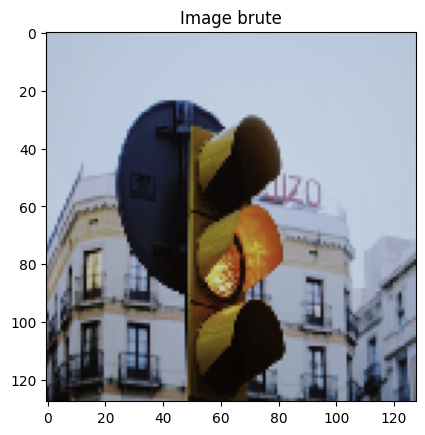

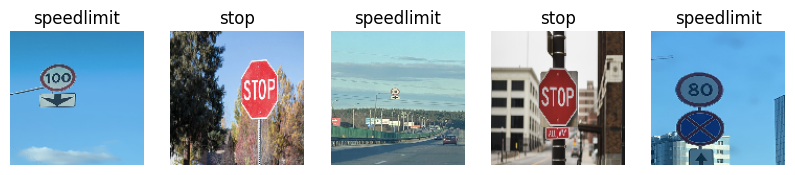

In [7]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Chemins vers les dossiers
image_dir = "/content/drive/MyDrive/road_sign/images"
annotation_dir = "/content/drive/MyDrive/road_sign/annotations"

# Initialisation des listes pour stocker les données
images = []
labels = []

# Parcourir les fichiers XML pour extraire les annotations
for xml_file in os.listdir(annotation_dir):
    if xml_file.endswith(".xml"):
        xml_path = os.path.join(annotation_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Récupérer le nom du fichier image (sans extension)
        filename = root.find("filename").text
        image_path = os.path.join(image_dir, filename)

        # Essayer de trouver l'image avec différentes extensions possibles
        possible_extensions = [".png", ".jpg", ".jpeg"]
        for ext in possible_extensions:
            if os.path.exists(image_path + ext):
                image_path += ext
                break

        # Récupérer le label (classe) de l'objet
        label = root.find("object/name").text

        # Charger l'image associée si elle existe
        if os.path.exists(image_path):
            image = tf.keras.utils.load_img(image_path, target_size=(128 , 128))  # Charger en 28x28
            image = tf.keras.utils.img_to_array(image)  # Convertir en tableau NumPy
            images.append(image)
            labels.append(label)

# Convertir les données en tableaux NumPy
images = np.array(images, dtype="float32") / 255.0  # Normaliser les pixels entre 0 et 1
labels = np.array(labels)

# Debugging: vérifier les premières images avant tout traitement supplémentaire
print("Vérification des valeurs des pixels :")
for i in range(3):
    print(f"Image {i}: Min={images[i].min()}, Max={images[i].max()}")

# Afficher une image brute pour confirmer qu'elle est correcte
plt.imshow(images[0])
plt.title("Image brute")
plt.show()

# Encodage des labels
label_to_index = {label: idx for idx, label in enumerate(['trafficlight', 'stop', 'speedlimit', 'crosswalk'])}
labels = np.array([label_to_index[label] for label in labels])

# Diviser les données en ensembles d'entraînement et de test
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Afficher les 5 premières images avec leur label
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_images[i])  # Afficher directement les images en RGB
    plt.title(list(label_to_index.keys())[train_labels[i]])
    plt.axis('off')

plt.show()


In [8]:
model = keras.Sequential([
    # Première couche convolutionnelle avec entrée plus grande
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Deuxième couche convolutionnelle
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Troisième couche convolutionnelle
    keras.layers.Conv2D(128, (3, 3), activation='relu'),

    # Quatrième couche convolutionnelle pour capturer encore plus de détails
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Aplatissement des données
    keras.layers.Flatten(),

    # Couches entièrement connectées
    keras.layers.Dense(256, activation='relu'),  # Plus de neurones pour gérer l'augmentation des informations
    keras.layers.Dropout(0.5),  # Régularisation pour éviter le surapprentissage
    keras.layers.Dense(128, activation='relu'),

    # Couche de sortie
    keras.layers.Dense(10, activation='softmax')  # Sortie pour 10 classes
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      11,075,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,498,442 (43.86 MB)

 Trainable params: 11,498,442 (43.86 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


22/22 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6365 - loss: 1.3644 - val_accuracy: 0.7159 - val_loss: 0.9190
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7453 - loss: 0.8420 - val_accuracy: 0.7443 - val_loss: 0.7829
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7598 - loss: 0.8501 - val_accuracy: 0.7443 - val_loss: 0.7622
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7870 - loss: 0.7435 - val_accuracy: 0.7500 - val_loss: 0.7983
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7576 - loss: 0.7734 - val_accuracy: 0.7500 - val_loss: 0.7441
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7824 - loss: 0.7005 - val_accuracy: 0.7443 - val_loss: 0.7102
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7862 - loss: 0.6527 - val_accuracy: 0.7443 - val_loss: 0.7120
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7782 - loss: 0.6444 - val_accuracy: 0.7443 - val_loss: 0.8730
Epo

6/6 - 3s - 569ms/step - accuracy: 0.7727 - loss: 0.6834


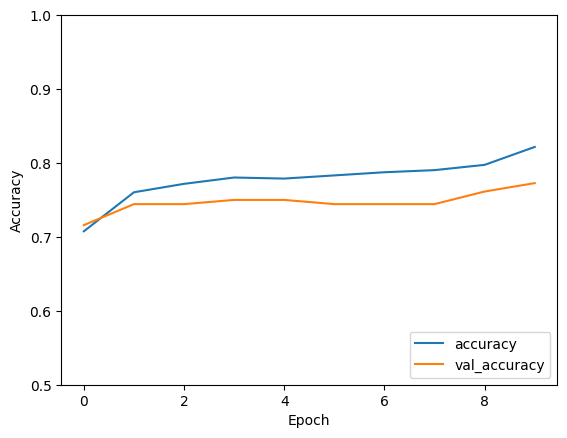

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [12]:
predictions = model.predict(test_images)

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


In [13]:
# Définir les noms des classes
class_names = ['trafficlight', 'stop', 'speedlimit', 'crosswalk']

import numpy as np

def check_predicted_labels(predictions, test_labels, class_names):
    for i in range(len(predictions)):
        predicted_label = np.argmax(predictions[i])
        # Accéder à l'étiquette réelle directement, car test_labels est unidimensionnel
        true_label = test_labels[i]
        predicted_probability = predictions[i][predicted_label]

        print(f"Image {i + 1}:")
        print(f"  True label: {class_names[true_label]}")
        print(f"  Predicted label: {class_names[predicted_label]} (probability: {predicted_probability:.2f})")
        print("-" * 20)

# Appeler la fonction avec les prédictions, les labels de test, et les noms de classe
check_predicted_labels(predictions, test_labels, class_names)


Image 1:
  True label: speedlimit
  Predicted label: speedlimit (probability: 0.88)
--------------------
Image 2:
  True label: speedlimit
  Predicted label: speedlimit (probability: 0.79)
--------------------
Image 3:
  True label: speedlimit
  Predicted label: speedlimit (probability: 0.85)
--------------------
Image 4:
  True label: speedlimit
  Predicted label: speedlimit (probability: 0.87)
--------------------
Image 5:
  True label: stop
  Predicted label: speedlimit (probability: 0.67)
--------------------
Image 6:
  True label: speedlimit
  Predicted label: speedlimit (probability: 0.87)
--------------------
Image 7:
  True label: speedlimit
  Predicted label: speedlimit (probability: 0.86)
--------------------
Image 8:
  True label: stop
  Predicted label: stop (probability: 0.58)
--------------------
Image 9:
  True label: speedlimit
  Predicted label: crosswalk (probability: 0.35)
--------------------
Image 10:
  True label: crosswalk
  Predicted label: speedlimit (probabili

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━

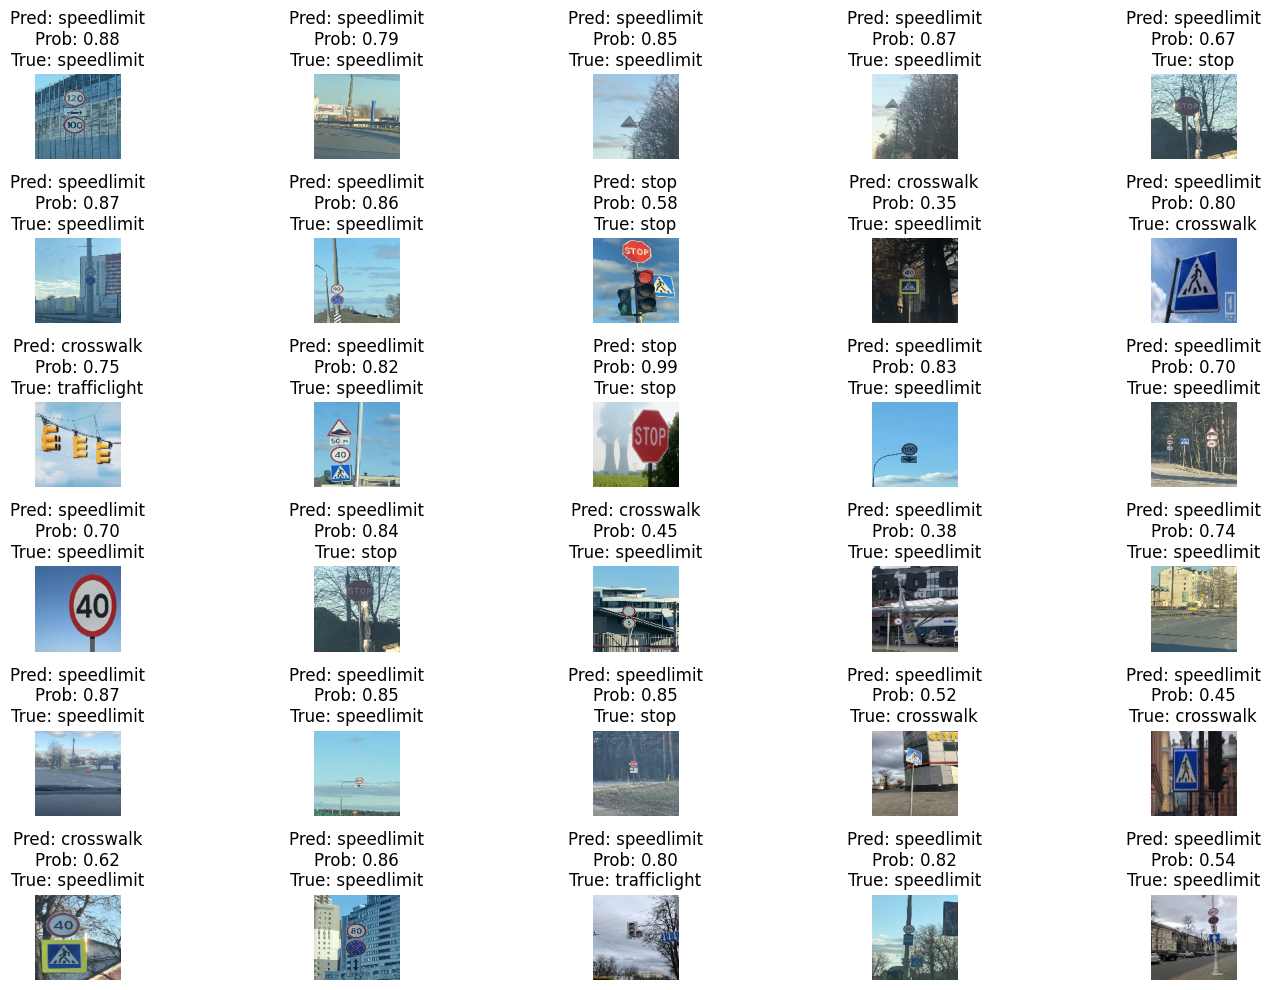

In [14]:
import numpy as np
import matplotlib.pyplot as plt

num_images = 30  # Number of images to predict

# Create a figure for displaying the images and their predictions
plt.figure(figsize=(15, 10))

for i in range(num_images):
    # Grab the image from the test set
    single_image = test_images[i]

    # Expand dimensions to add batch size dimension
    single_image_expanded = np.expand_dims(single_image, axis=0)

    # Make a prediction using the model
    predicted_probabilities = model.predict(single_image_expanded)

    # Get the predicted class and probability
    predicted_label = np.argmax(predicted_probabilities[0])
    predicted_probability = np.max(predicted_probabilities[0])

    # Display the image
    plt.subplot(6, 5, i + 1)  # 6 rows, 5 columns layout for 30 images
    plt.imshow(single_image, cmap='gray')  # Use 'gray' for grayscale images
    plt.axis('off')  # Turn off axis labels

    # Ensure test_labels[i] is converted to an integer if needed
    true_label_index = int(test_labels[i]) if isinstance(test_labels[i], (np.ndarray, list)) else test_labels[i]

    plt.title(f"Pred: {class_names[predicted_label]}\nProb: {predicted_probability:.2f}\nTrue: {class_names[true_label_index]}")

# Adjust layout and show the plot with all images and predictions
plt.tight_layout()
plt.show()

